# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

## **Import**

In [ ]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import numpy as np
from sklearn import metrics
import random
import random

import torch
import torchvision
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torchvision.models.resnet import BasicBlock

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FakeData, CIFAR10





### ***Further settings***

In [27]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 808
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

# ***Import Exercise1 ResCNN_Model architecture and weights***

In [28]:

class VariableDepthResNet(nn.Module):
    def __init__(self, num_blocks, num_classes, base_channels, dropout_rate, in_channels, padding):
        super().__init__()
        # Initial convolution + batch norm + activation
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)

        # Stack residual blocks
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(base_channels, base_channels))
        self.res_blocks = nn.Sequential(*layers)

        # Global average pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout + final classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(base_channels, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.res_blocks(x)                  
        x = self.pool(x)                       
        x = torch.flatten(x, 1)                  
        x = self.dropout(x)                     
        return self.fc(x)                        



#model istance
model = VariableDepthResNet(
    num_blocks=4,
    num_classes=10,
    base_channels=32,
    dropout_rate=0.2,
    in_channels=3,
    padding=1
).to(device)

state_dict = torch.load( r"C:\UNIFI\LM Bio UniFi\II ANNO\SECONDO SEMESTRE\APPLI OF MACHINE LEARNING\AML_Labs\Exercise_1\models\best_model_ResCNN.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

C:\Users\emile\AppData\Local\Temp\ipykernel_19272\3625359872.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load( r"C:\UNIFI\LM Bio UniFi\II ANNO\SE

VariableDepthResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (res_blocks): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=

### **Load Data CIFAR-10**

In [ ]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                         num_workers=8, persistent_workers=True)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, 
                        num_workers=8, persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified


### **Load Fake dataset**

In [39]:

fakeset = FakeData(size=1000, image_size=(3,32,32), transform=transform)
fakeloader = DataLoader(fakeset, batch_size=128, shuffle=False)

### *Visualize a sample from FakeData*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


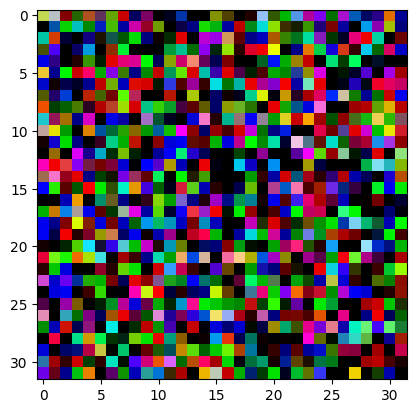

torch.Size([128, 3, 32, 32]) airplane


In [23]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0].permute(1, 2, 0))  # convert from (C,H,W) to (H,W,C)
    plt.show()
    break

print(x.shape, trainset.classes[y[80]])

## **scores function**

In [40]:
def get_max_softmax_scores(model, dataloader, device):
    model.eval()
    scores = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            max_scores, _ = torch.max(probs, dim=1)
            scores.extend(max_scores.cpu().numpy())
    return np.array(scores)


## **Model evaluation**

Accuracy: 0.7705


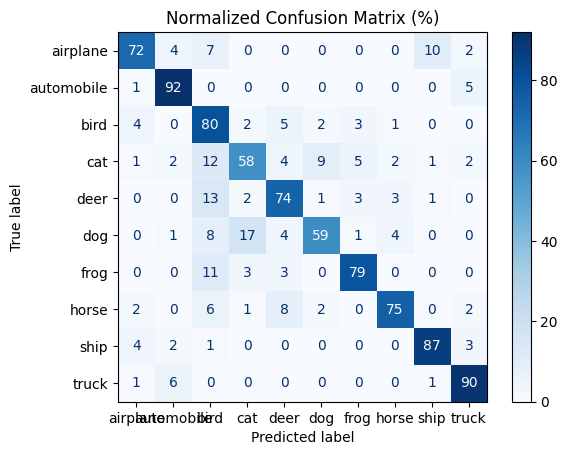

In [ ]:
# Ensure the model is in evaluation mode
model.eval()
y_pred = []
y_gt = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predicted class
        preds = torch.argmax(outputs, dim=1)
        
    
        y_pred.append(preds.cpu())
        y_gt.append(labels.cpu())

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)
accuracy = metrics.accuracy_score(y_gt_t.numpy(), y_pred_t.numpy())
print(f'Accuracy: {accuracy:.4f}')

# Compute confusion matrix
cm = metrics.confusion_matrix(y_gt_t.numpy(), y_pred_t.numpy())
cmn = cm.astype(np.float32)
cmn /= cmn.sum(axis=1)[:, np.newaxis]
# Convert to percentages
cmn = (100 * cmn).astype(np.int32)

disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Normalized Confusion Matrix (%)")
plt.show()


### **Logits and Softmax plot for OOD and ID**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58143103..1.7085817].


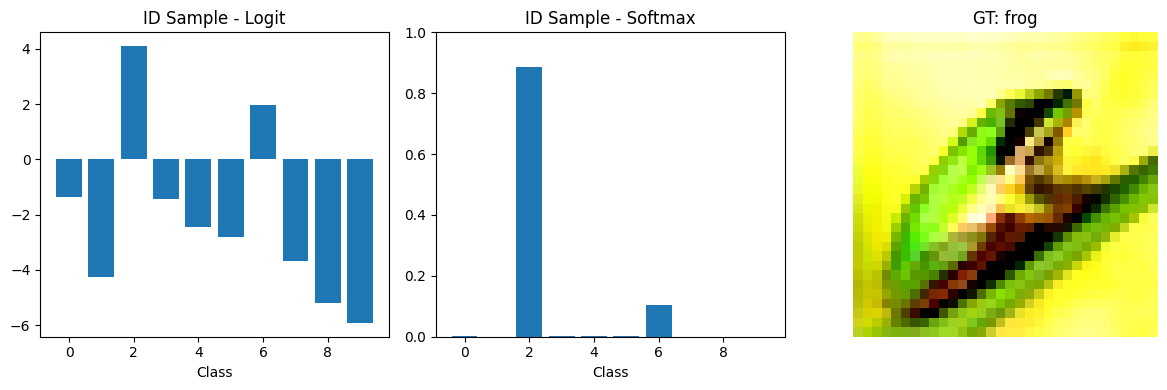

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


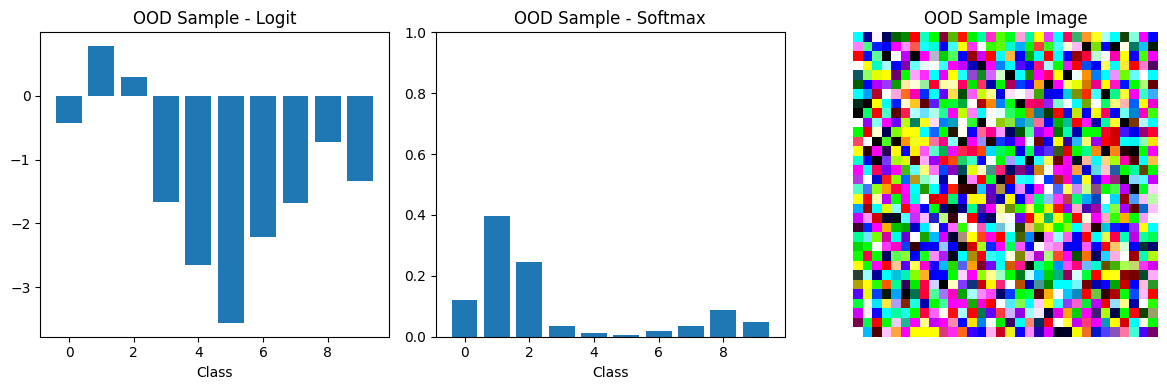

In [ ]:
model.eval()
# Pick one random sample from ID dataset
x_id, y_id = next(iter(testloader))
k_id = random.randint(0, x_id.shape[0]-1)
x_id, y_id = x_id.to(device), y_id.to(device)

# Pick one random sample from OOD dataset
x_ood, _ = next(iter(fakeloader))
k_ood = random.randint(0, x_ood.shape[0]-1)
x_ood = x_ood.to(device)

 # Plots logit, softmax, and image for a single sample from a batch.
def plot_sample_logit_softmax_image(x_batch, k, title, y_batch=None, class_names=None):

    with torch.no_grad():
        output = model(x_batch)
    
    logits = output[k].detach().cpu()
    softmax_probs = F.softmax(output, dim=1)[k].detach().cpu()
    plt.figure(figsize=(12,4))
    
    # Logit plot
    plt.subplot(1,3,1)
    plt.bar(range(len(logits)), logits)
    plt.title(f'{title} - Logit')
    plt.xlabel('Class')
    # Softmax plot
    plt.subplot(1,3,2)
    plt.bar(range(len(softmax_probs)), softmax_probs)
    plt.title(f'{title} - Softmax')
    plt.ylim(0,1)
    plt.xlabel('Class')
    # Image
    plt.subplot(1,3,3)
    img = x_batch[k].cpu().permute(1,2,0)

    # Undo normalization for visualization
    img = img * 0.5 + 0.5
    plt.imshow(img)
    if y_batch is not None and class_names is not None:
        plt.title(f'GT: {class_names[y_batch[k].cpu()]}')
    else:
        plt.title(f'{title} Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_logit_softmax_image(x_id, k_id, "ID Sample", y_id, testset.classes)
plot_sample_logit_softmax_image(x_ood, k_ood, "OOD Sample")


## ***overlapping histogram***

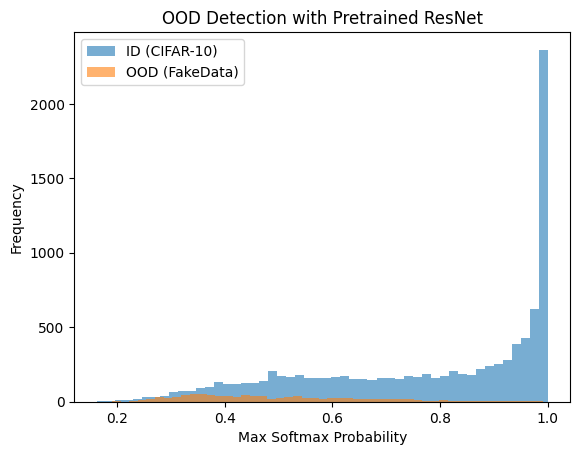

In [42]:
id_scores = get_max_softmax_scores(model, testloader, device)
ood_scores = get_max_softmax_scores(model, fakeloader, device)

#Plot scores
plt.hist(id_scores, bins=50, alpha=0.6, label="ID (CIFAR-10)")
plt.hist(ood_scores, bins=50, alpha=0.6, label="OOD (FakeData)")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Frequency")
plt.legend()
plt.title("OOD Detection with Pretrained ResNet")
plt.show()

In [12]:
load_resnet = False
load = False
if not load_resnet and not load:
    epochs = 50
    for e in range(epochs):
        running_loss = 0
        for it, data in enumerate (trainloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            
            yp = model(x)
            l = loss(yp, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
            #if it % 100 == 0:
            #    print(it, l.item())
        print(e, running_loss/len(trainloader))
    torch.save(model.state_dict(), f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth')      

0 1.808469690020432
1 1.4501038426938264
2 1.3011744586403107
3 1.1952284266576743
4 1.1185863025657965
5 1.0412783887989991
6 0.9635530955651227
7 0.8869998252300351
8 0.8095974704188764
9 0.727770406724242
10 0.6443541664296709
11 0.5562184453010559
12 0.4631744797729775
13 0.3726837002407864
14 0.2818627173028639
15 0.20577499017005077
16 0.14915958678592806
17 0.11085559580179737
18 0.08245656477844776
19 0.06866246241304423
20 0.05503939759567418
21 0.06402408894713578
22 0.04856691056924403
23 0.0445474892702249
24 0.040352551726257554
25 0.04920034500224816
26 0.026774960496198492
27 0.03677562042199018
28 0.04484215476061872
29 0.030721696863031906
30 0.03265746832941956
31 0.031239762043585178
32 0.028975806104035957
33 0.03578016558862136
34 0.025954850260680423
35 0.022145421058118172
36 0.024116911442445405
37 0.033248547320801985
38 0.02699492041103761
39 0.021703598035923432
40 0.02056065816378645
41 0.02479587253683325
42 0.023483645095004013
43 0.025966197347549527
44 0

In [13]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load:
    model = CNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))

In [14]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load_resnet:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
    model.eval()
    model.cuda()
    

In [15]:
#here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)
        

Accuracy: 0.6200999617576599


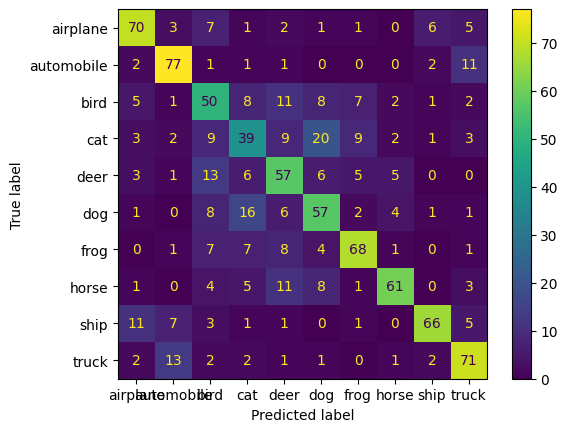

In [16]:
#Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot()
plt.show()


In [17]:
cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)
print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

Per class accuracy: 0.6201


In [18]:
for data in testloader:
    x, y = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

for data in fakeloader:
    xfake, _ = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break



GT: 9, truck


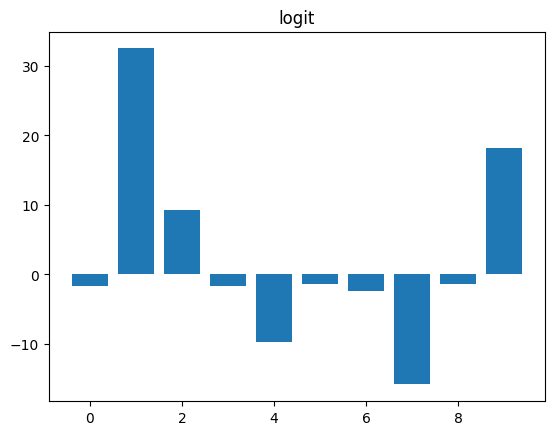

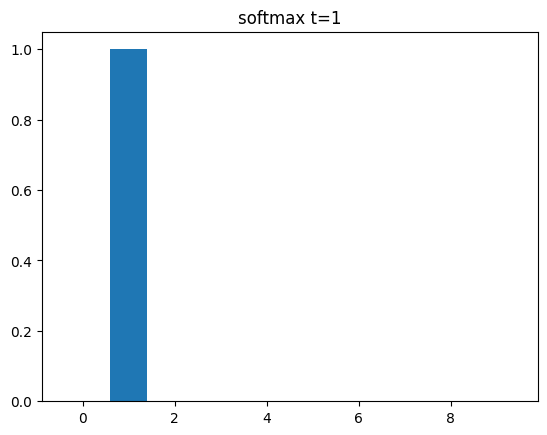

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


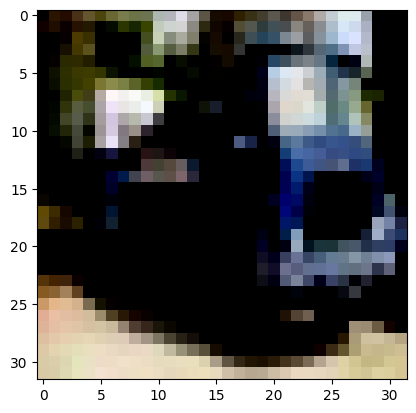

In [19]:
import random
#Example of logit and softmax output
#k=0#the kth sample of the batch
k=random.randint(0,x.shape[0])
print(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label
output = model(x.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(x[k,:].permute(1,2,0))
plt.show()


    

In [20]:
x.shape

torch.Size([128, 3, 32, 32])

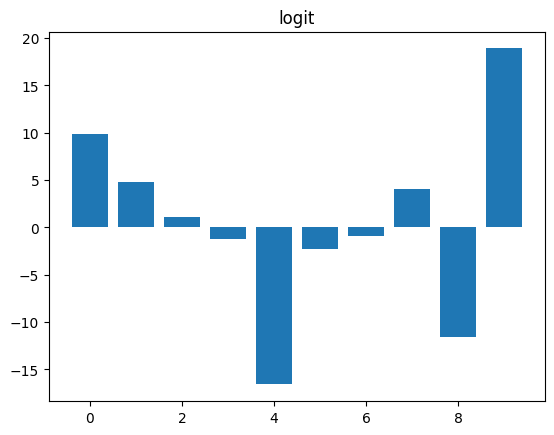

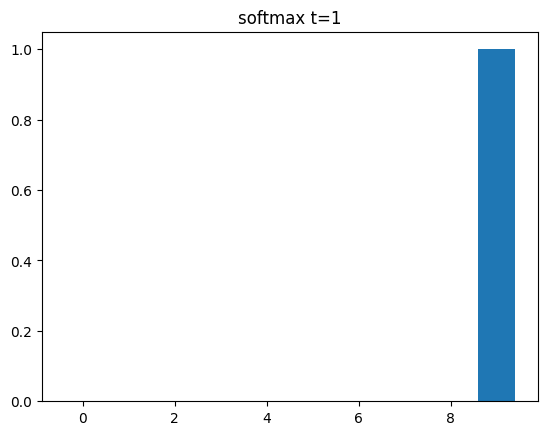

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


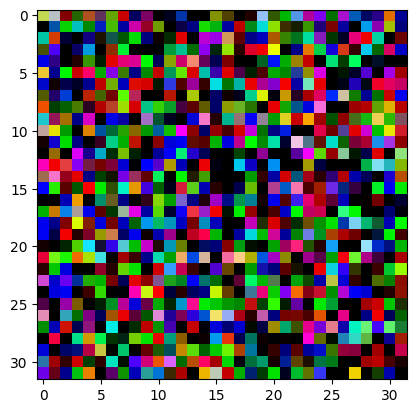

In [21]:
#Example of logit and softmax output
k=0#the kth sample of the batch
output = model(xfake.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0))
plt.show()


    

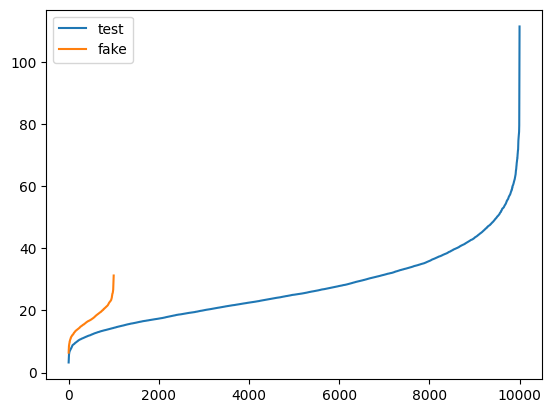

In [22]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=1
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)

        
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()



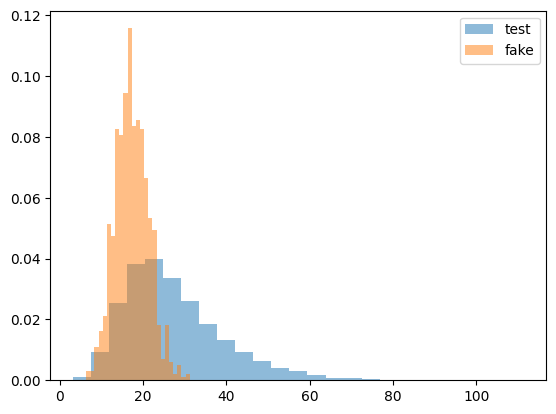

In [23]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()


In [24]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [25]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [26]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 0.3180888608441024
1 0.20283584106151406
2 0.18857008150166563
3 0.1775920304191082
4 0.17147543748168995
5 0.16843970055165497
6 0.16605195505997103
7 0.16278062783696157
8 0.16044540954825212
9 0.15900601755322702
10 0.1579100773157671
11 0.15701559189792788
12 0.15630607017318307
13 0.1557230824399787
14 0.15517364514758214
15 0.15466893001285661
16 0.15407295380254535
17 0.15355279481471956
18 0.15309906089702224
19 0.15266059319991285


In [27]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)
        
scores_fake_ae = torch.cat(scores_fake_ae)



scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)
        
scores_test_ae = torch.cat(scores_test_ae)



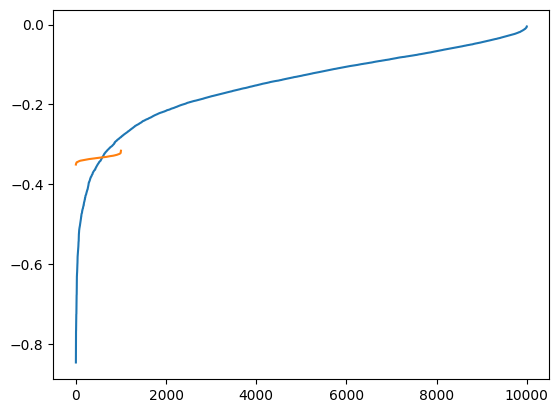

In [28]:
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))


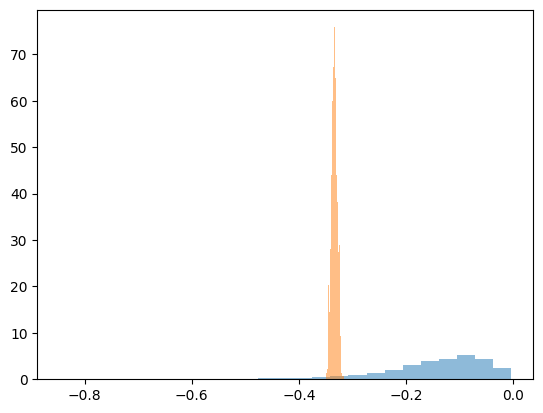

In [29]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



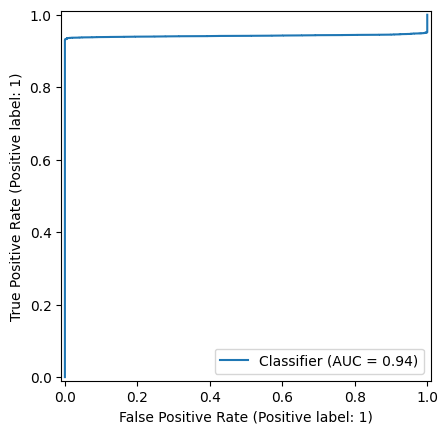

In [30]:
#AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

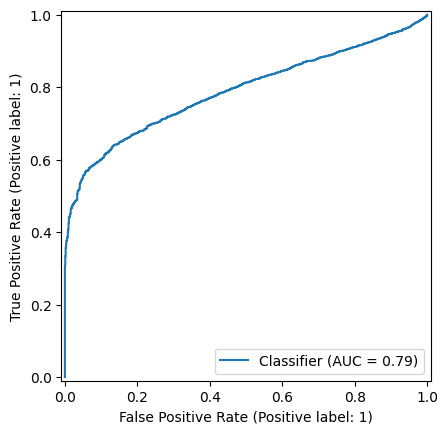

In [31]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [32]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [33]:
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


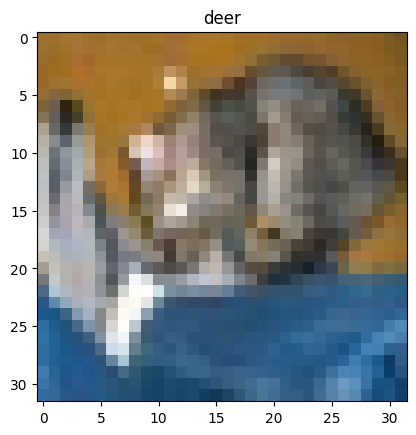

classifier is already wrong or target label same as GT!


In [34]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['deer']
eps = 1/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone()
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted
        
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())
    






In [35]:
x.shape

torch.Size([1, 3, 32, 32])

In [36]:
diff.squeeze().mean(0).shape
plt.imshow(255*diff.cpu().detach().squeeze().mean(0))
plt.colorbar()

NameError: name 'diff' is not defined

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
# Your code here.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
